In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

cmap = mpl.cm.jet

In [3]:
PATH = "electromigration_8/GBN_ET2_"
N_RANGE = (508, 569)
file_list = lambda nrange : [PATH + '{0:03}.dat'.format(i) for i in range(*nrange)]

In [4]:
def file2df(file):
    with open(file,'r') as f:
        for i in range(70): # 70 for .dat, 8 for transport__.dat
            f.readline()
        df = pd.read_table(f)
        df = df.rename(columns={"Bias calc (V)": "V", "LI Y [AVG] (V)": "LIY"})
        return df
df = file2df(file_list(N_RANGE)[0])
df.head()

V  Current [AVG] (A)  LI X [AVG] (V)       LIY  Current [00001] (A)  \
0  0.500000       9.395400e-12        0.366443  0.128989         6.330290e-12   
1  0.498043       9.407360e-12        0.363825  0.131790         6.439700e-12   
2  0.496086       9.181850e-12        0.363404  0.130333         6.329650e-12   
3  0.494129       9.127780e-12        0.365635  0.128696         6.177790e-12   
4  0.492172       9.041890e-12        0.364537  0.129369         6.257320e-12   

   LI X [00001] (V)  LI Y [00001] (V)  Current [00002] (A)  LI X [00002] (V)  \
0          0.365559          0.087563         1.076370e-11          0.367052   
1          0.362472          0.088814         1.099030e-11          0.366400   
2          0.362862          0.086042         1.066640e-11          0.363738   
3          0.366428          0.087812         1.058180e-11          0.368079   
4          0.365299          0.091574         1.057120e-11          0.364563   

   LI Y [00002] (V)  Current [00003] (A)  LI X [00003] (V)  LI Y [00003] (V)  
0          0.151855         1.109230e-11          0.366718          0.147548  
1          0.153852         1.079210e-11          0.362603          0.152704  
2          0.155690         1.054940e-11          0.363610          0.149267  
3          0.151294         1.062380e-11          0.362399          0.146982  
4          0.149863         1.029720e-11          0.363747          0.146671

In [5]:
from scipy.signal import gaussian, fftconvolve, find_peaks
def find_min(df, guess=0.3, sig=5, dist=10, min_prom=0.7e-2, phon_correct=True, filenum=0):
    a = fftconvolve(df.LIY, gaussian(50, std=sig), mode='same')
    peaks, _ = find_peaks(-a, prominence=(min_prom, None), distance=dist)
    plt.figure()
    plt.plot(df.V, df.LIY)
    for p in peaks:
        plt.axvline(x=df.V[p])
    m = min(df.V[peaks], key=lambda x:abs(x-guess))
    plt.axvline(x=m, color='r')
    plt.title("{}".format(filenum))
    return m

0.10686683941126446

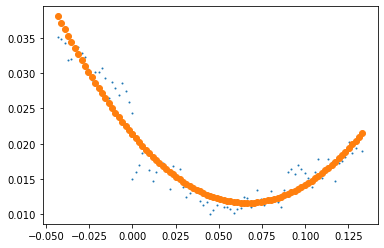

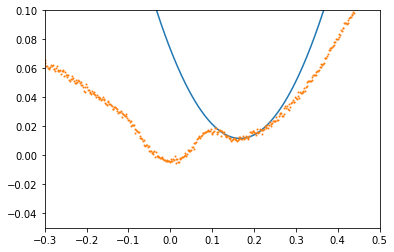

In [6]:
from scipy.optimize import curve_fit

def fit_dirac(df, crop=(-0.1, 0.1), fit_window=(-0.09, 0.09), right=True, fname=None):
    """
    Fits diract point using 4 step process
    1.) crop out phonon gap (set by crop parameter) and merge at center of crop
    2.) fit data to parabola on fit_interval
    3.) add back shift from data crop
    4.) subtract out real phonon gap (0.06V)
    
    Plots fits vs. real data as side effect
    """
    
    V_left = df[df.V < crop[0]].V
    V_right = df[df.V > crop[1]].V
    LIY_left = df[df.V < crop[0]].LIY
    LIY_right = df[df.V > crop[1]].LIY
    if right:
        V_left = V_left - np.max(V_left)
        crop_shift = np.min(V_right)
        V_right = V_right - crop_shift
    else:
        crop_shift = np.max(V_left)
        V_left = V_left - crop_shift
        V_right = V_right - np.min(V_right)
    V_cropped = pd.concat([V_left, V_right])
    LIY_cropped = pd.concat([LIY_left, LIY_right])
    LIY_cropped = LIY_cropped
    V_cropped = V_cropped[~LIY_cropped.isna()]
    LIY_cropped = LIY_cropped[~LIY_cropped.isna()]
    V_min = V_cropped.loc[LIY_cropped.idxmin()]
    fit_interval = (V_cropped < V_min + fit_window[1]) & (V_cropped > V_min + fit_window[0])
    V_fit, LIY_fit = V_cropped[fit_interval], LIY_cropped[fit_interval]
    plt.figure()
    if fname:
        plt.title(fname)
    plt.plot(V_fit, LIY_fit, 'o', markersize=1)
    fit_parms = np.polyfit(V_fit, LIY_fit, 2)
    a, b, c = fit_parms
    h = -b / (2 * a)
    k = c - b**2 / (4 * a)
    plt.plot(V_fit, a * (V_fit - h) ** 2 + k, 'o')
    h += crop_shift
    plt.figure()
    plt.plot(df.V, a * (df.V - h) ** 2 + k)
    plt.plot(df.V, df.LIY, 'o', markersize=1)
    plt.xlim(-0.3, 0.5)
    plt.ylim(-0.05, 0.1)
    if right:
        return h - 0.06
    else:
        return h + 0.06
#     return h - 0.06
fit_dirac(df)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


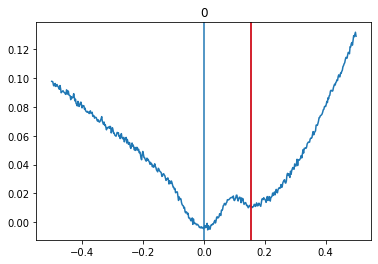

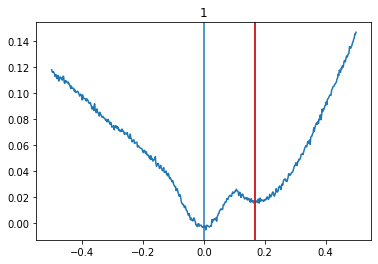

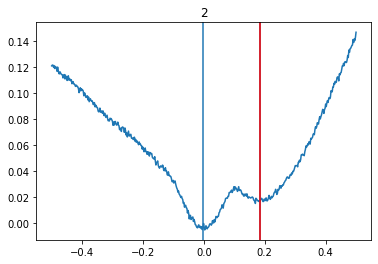

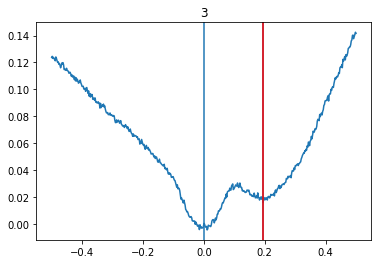

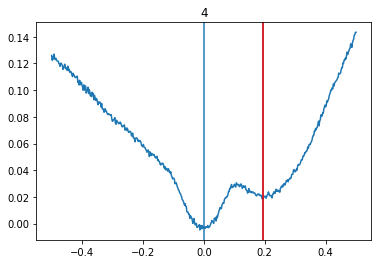

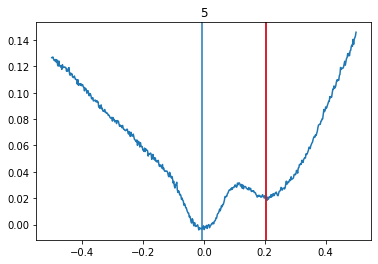

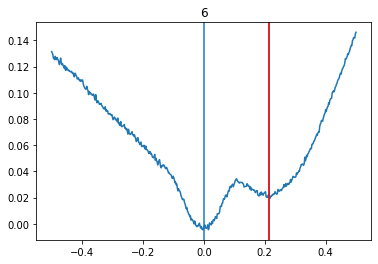

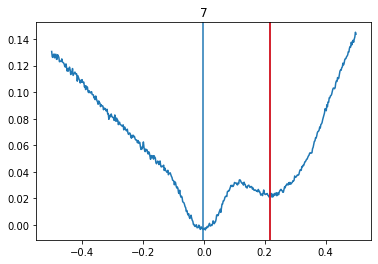

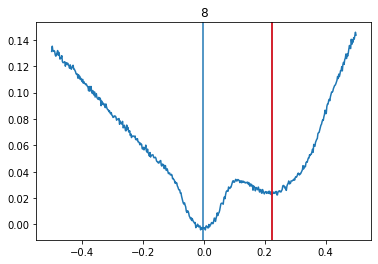

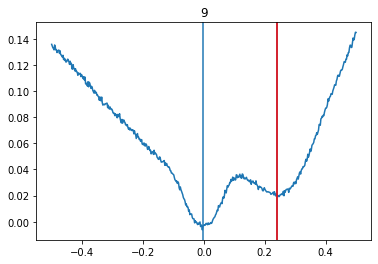

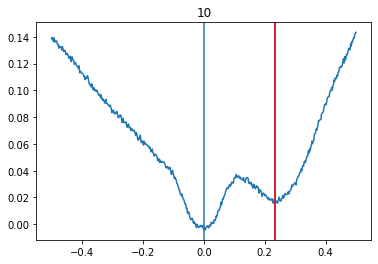

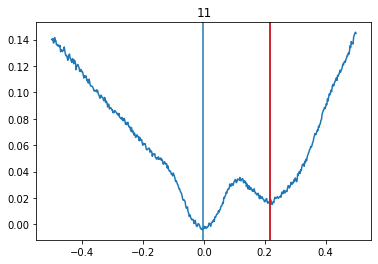

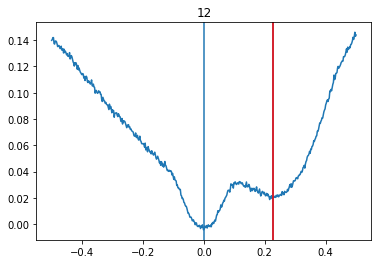

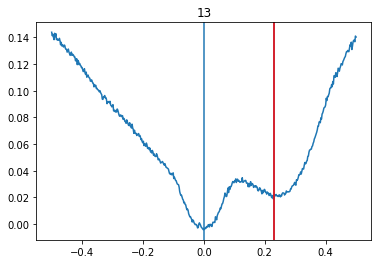

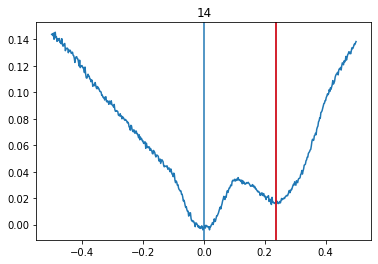

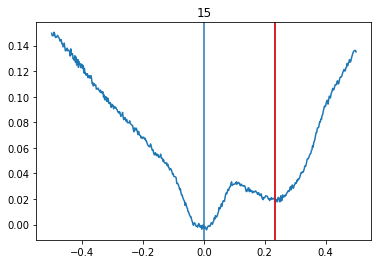

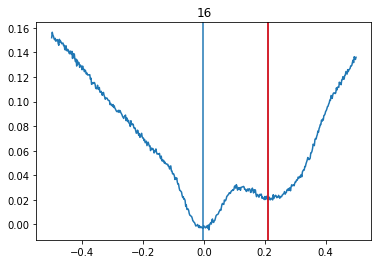

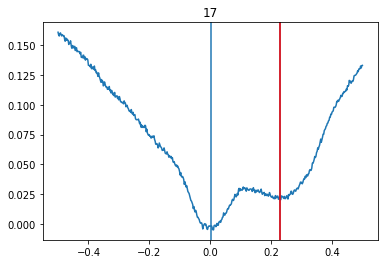

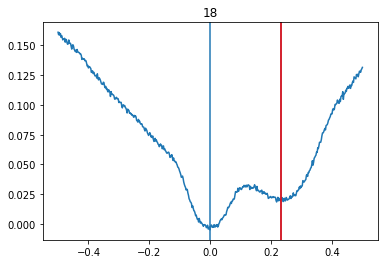

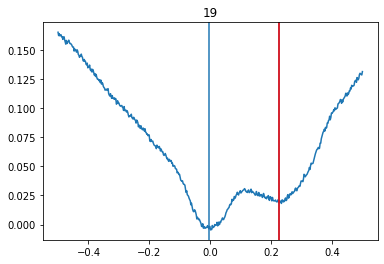

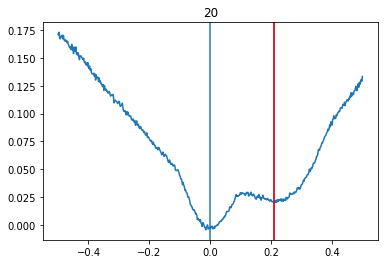

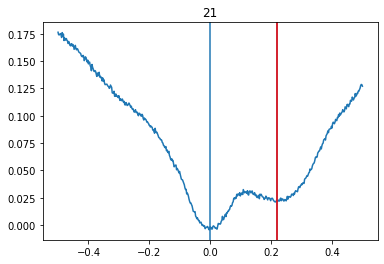

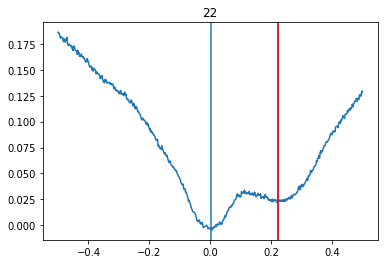

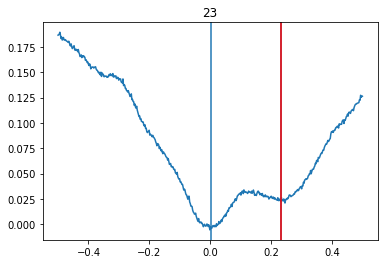

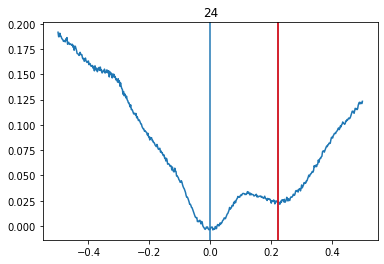

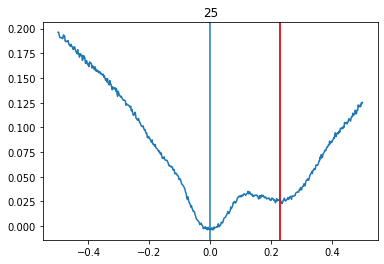

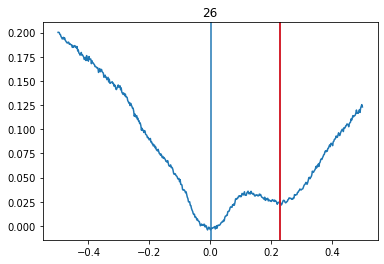

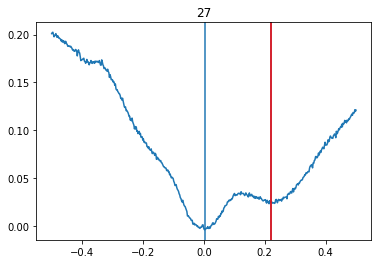

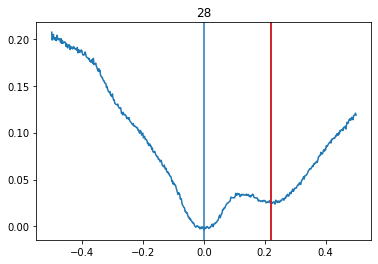

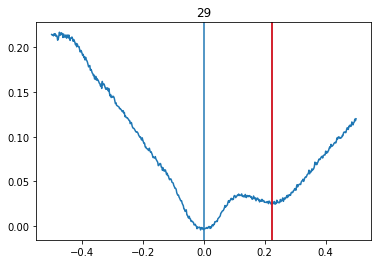

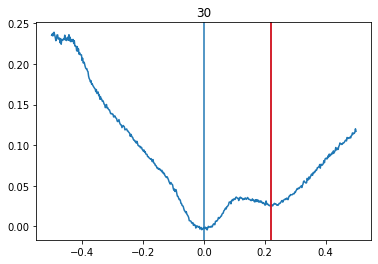

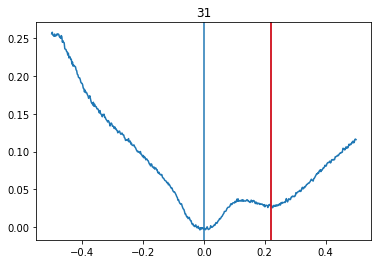

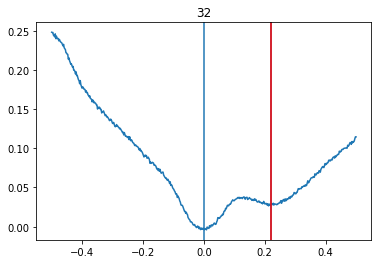

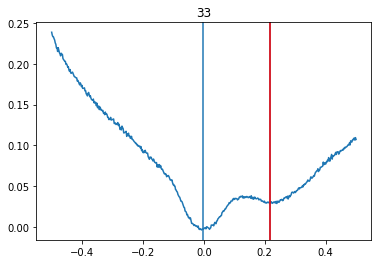

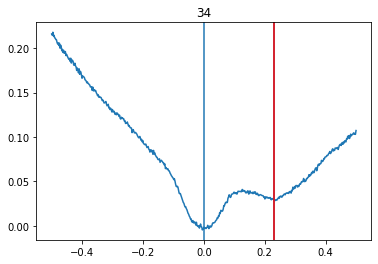

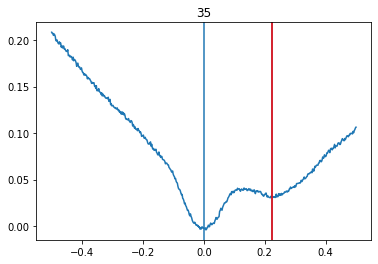

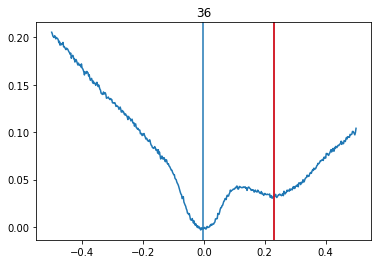

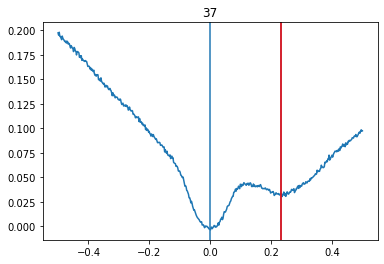

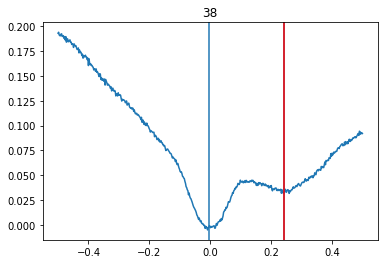

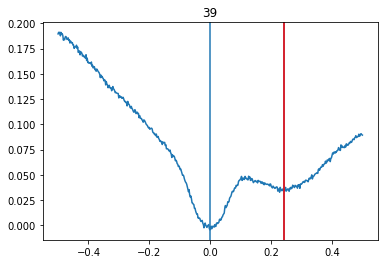

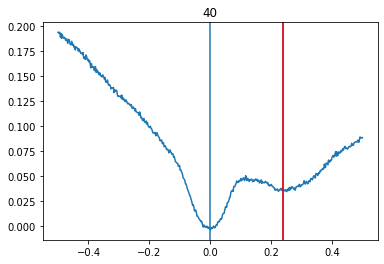

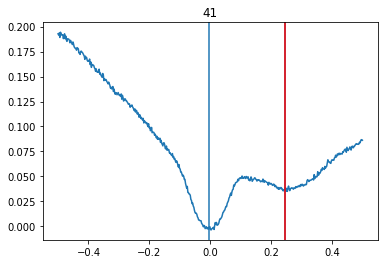

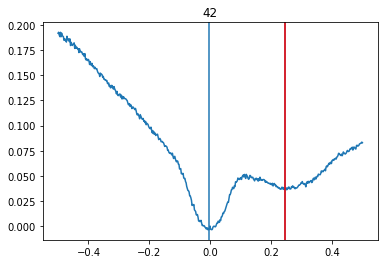

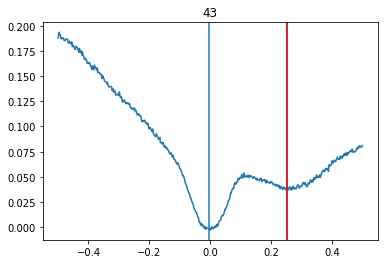

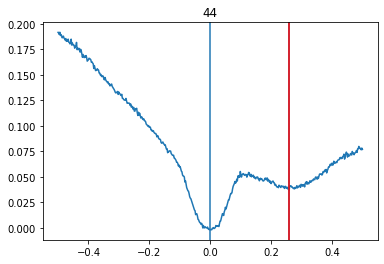

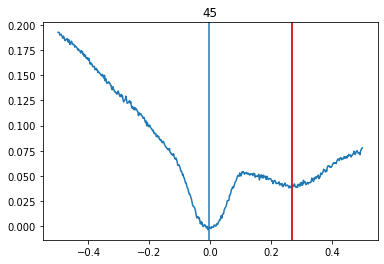

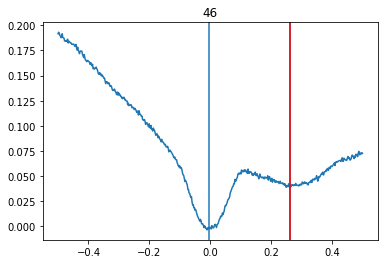

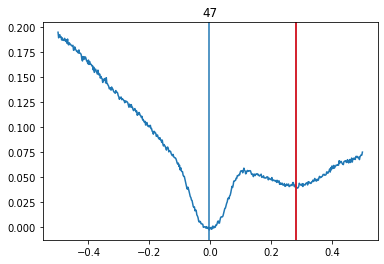

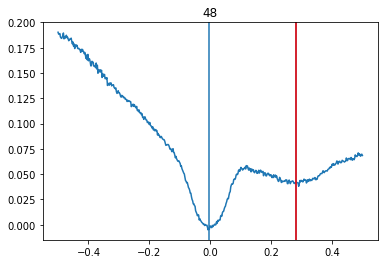

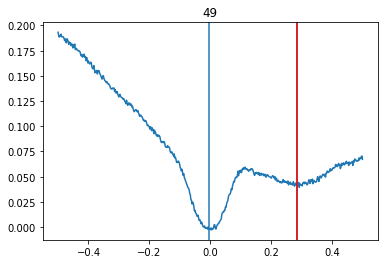

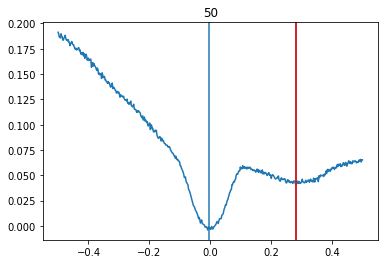

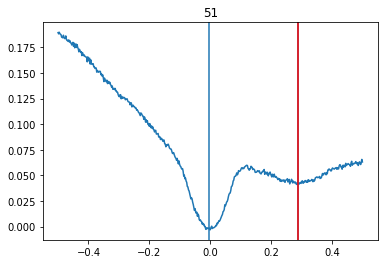

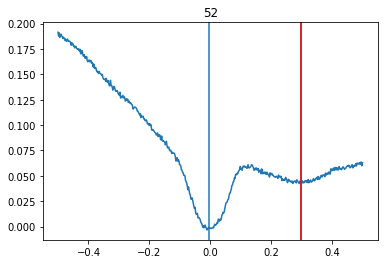

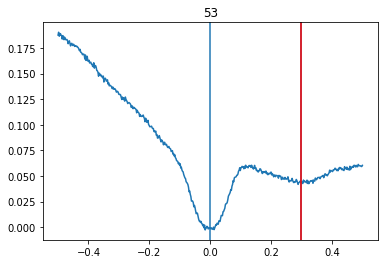

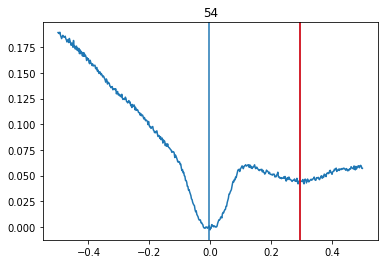

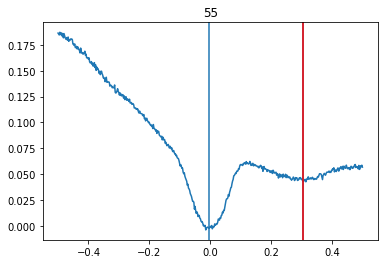

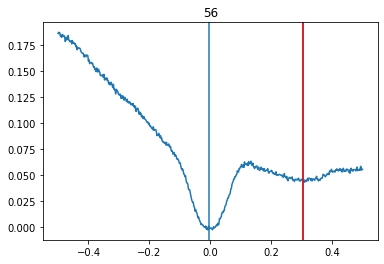

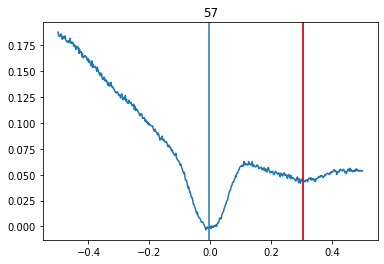

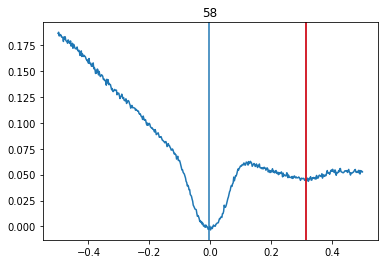

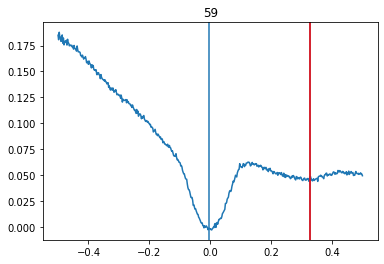

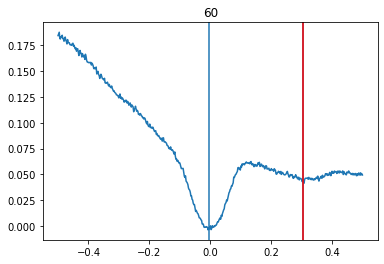

In [14]:
N_RANGE = (508, 569)
files = file_list(N_RANGE)
c = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 70:
        c.append(find_min(df, guess=0.3, sig=6, dist=10, min_prom=7e-3, phon_correct=True, filenum=i))
    else:
        c.append(find_min(df, guess=-0.3, sig=6, dist=10, min_prom=7e-3, phon_correct=True, filenum=i))
        

(-0.3, 0.35)

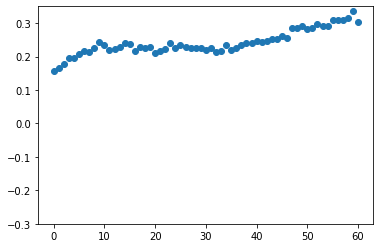

In [13]:
# V = np.linspace(-60, 60, 61)
plt.plot(np.array(c[:]), 'o')
plt.ylim(-0.3, 0.35)

In [ ]:
N_RANGE = (447, 508)
files = file_list(N_RANGE)
d = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 5:
        d.append(fit_dirac(df, crop=(-0.05, 0.05), fit_window=(-0.15, 0.15), right=False, fname=f))
    else:
        d.append(find_min(df, guess=0.2, sig=10))

(-0.3, 0.3)

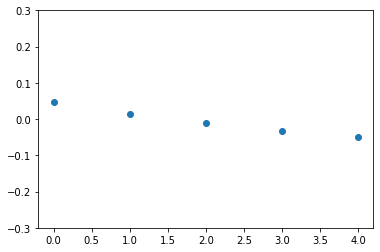

In [27]:
plt.plot(np.array(d[::-1]), 'o')
plt.ylim(-0.3, 0.3)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


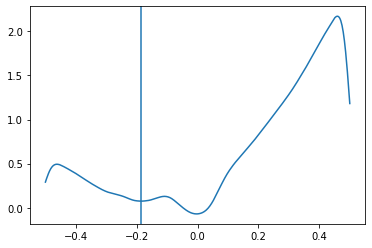

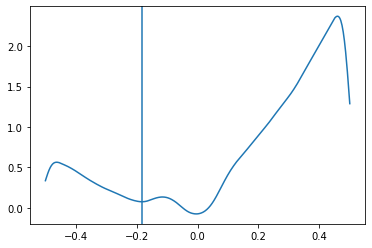

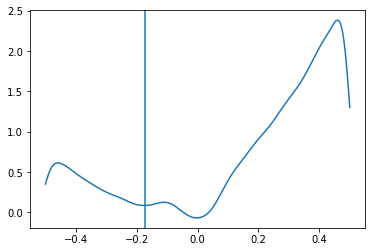

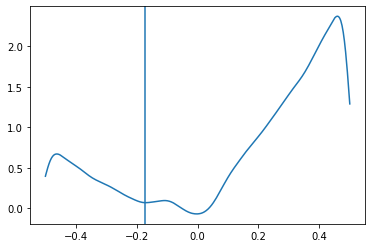

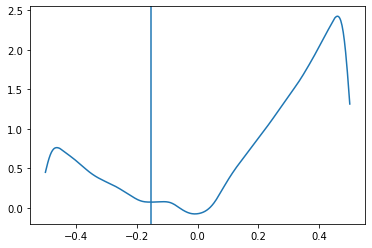

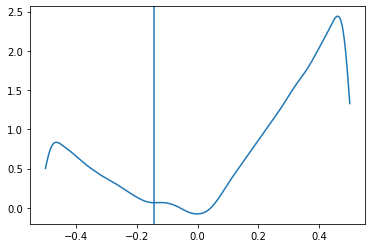

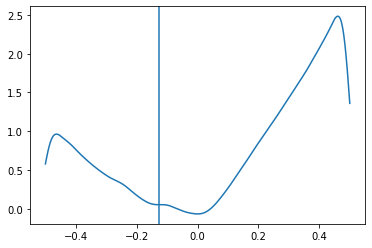

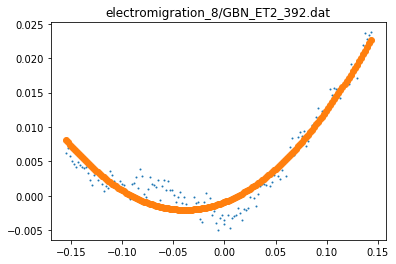

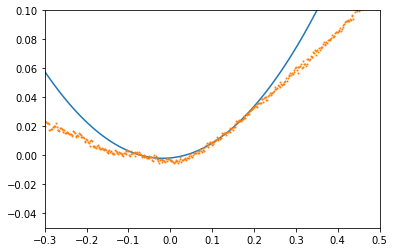

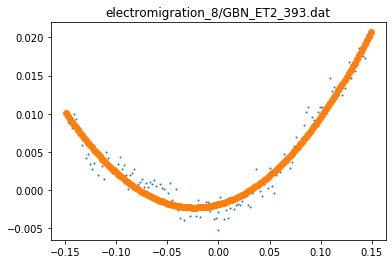

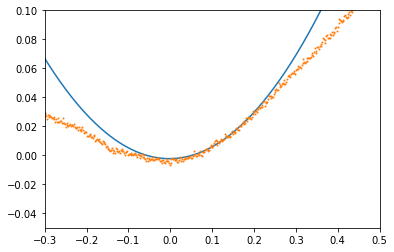

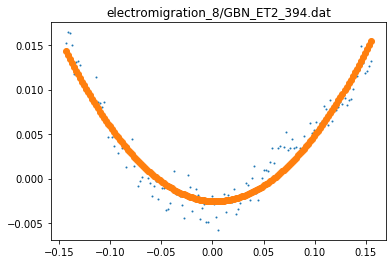

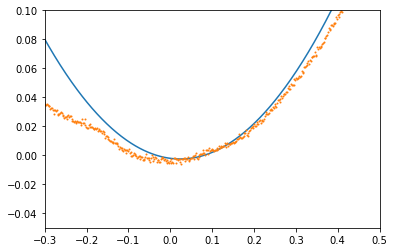

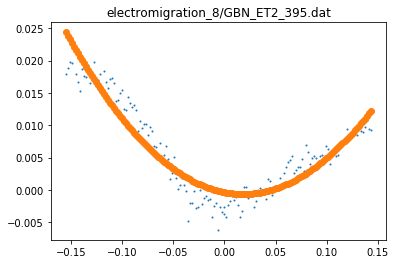

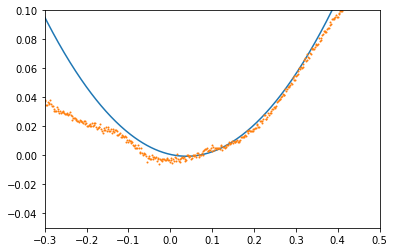

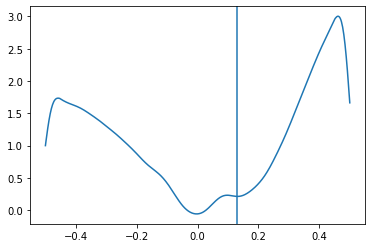

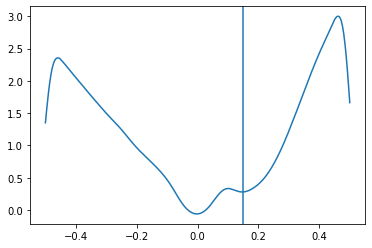

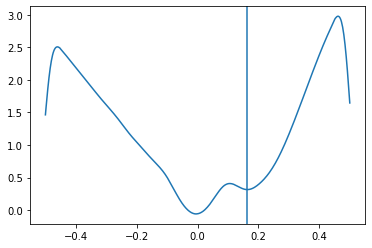

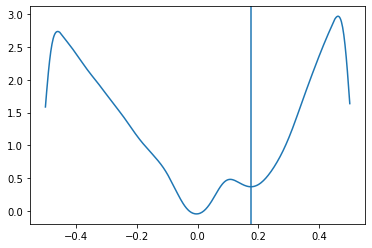

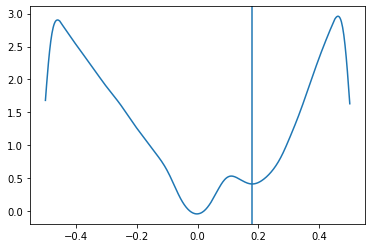

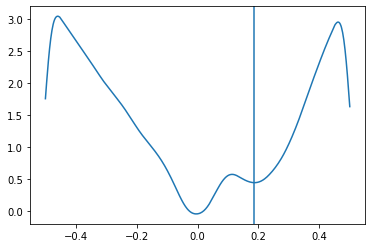

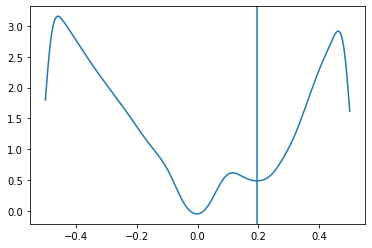

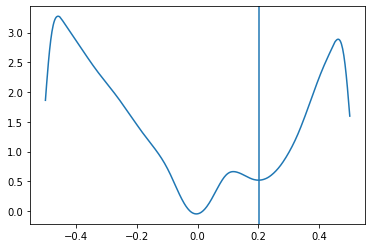

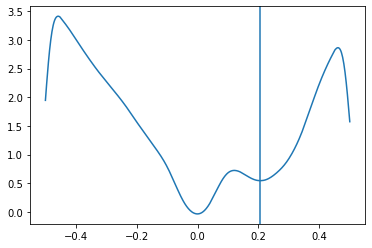

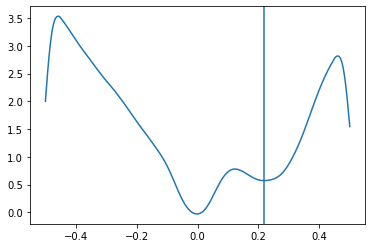

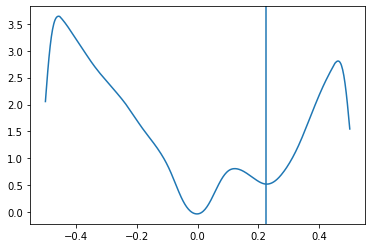

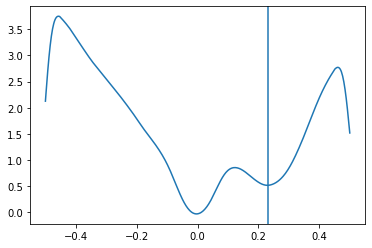

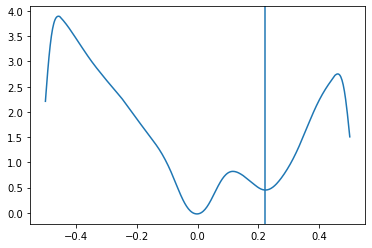

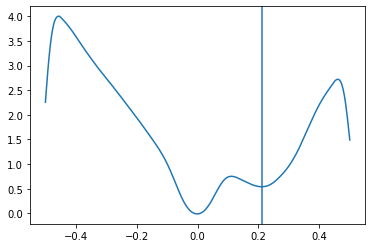

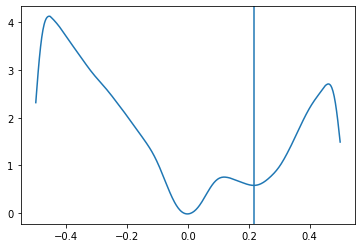

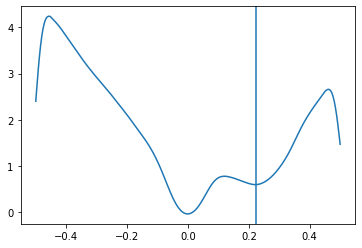

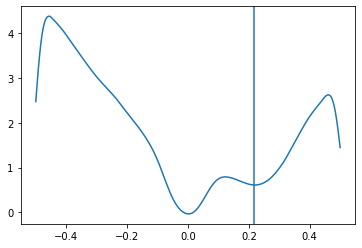

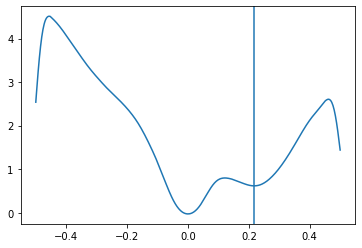

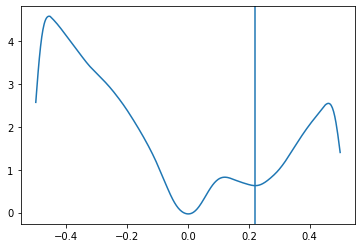

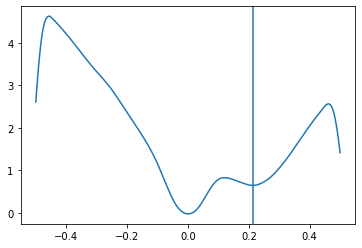

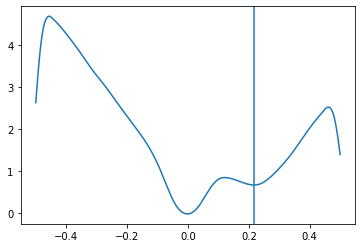

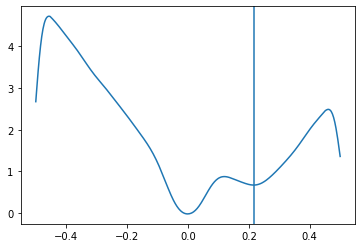

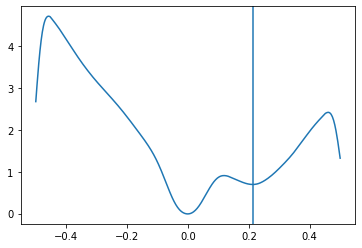

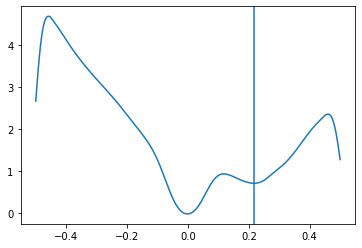

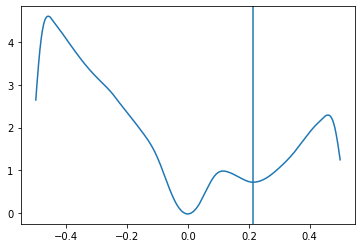

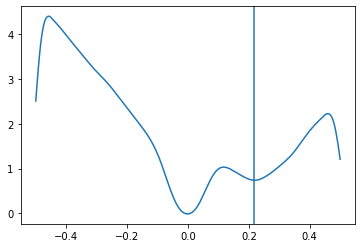

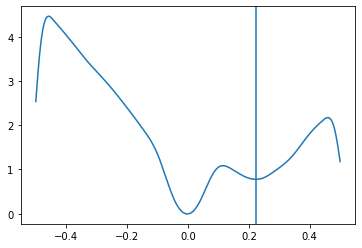

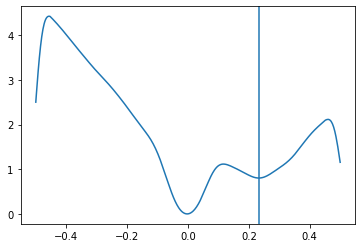

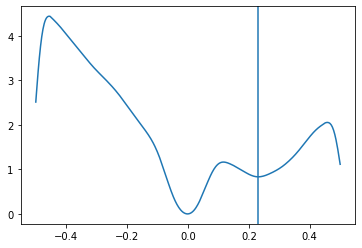

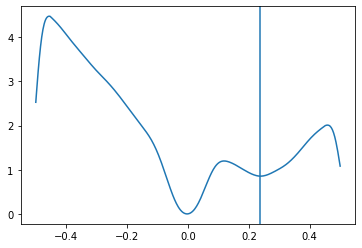

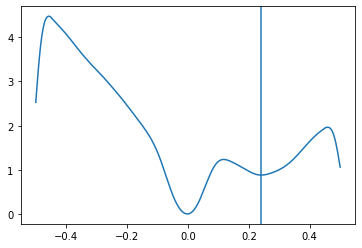

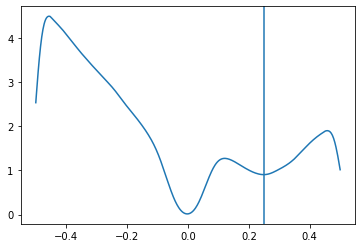

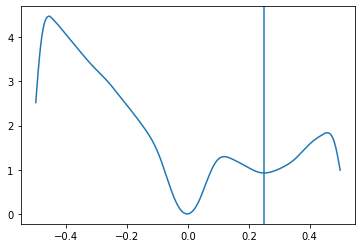

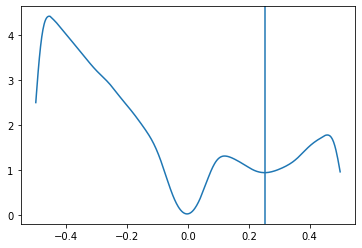

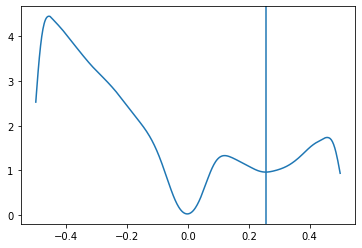

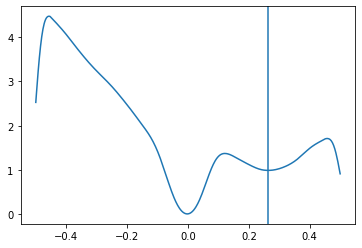

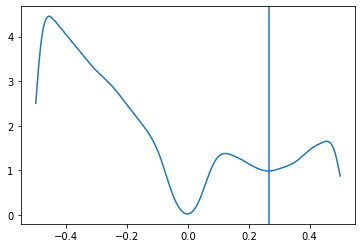

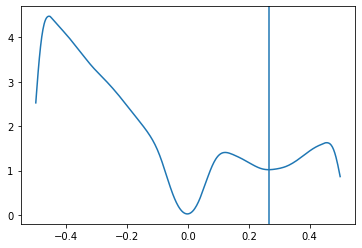

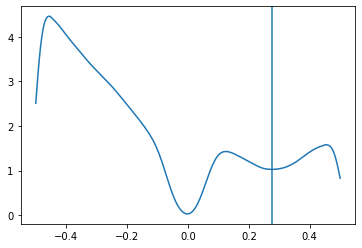

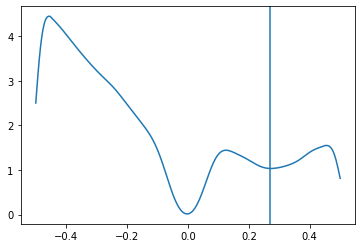

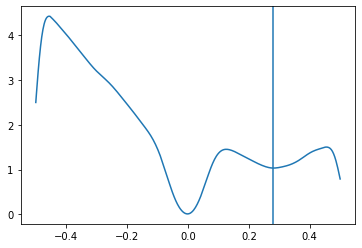

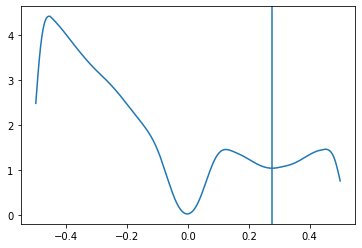

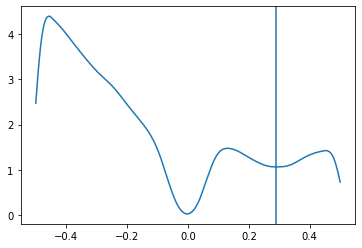

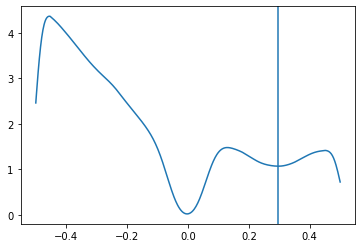

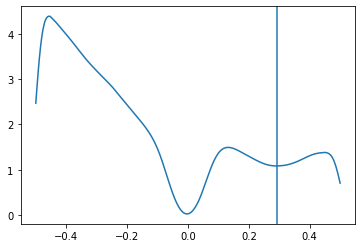

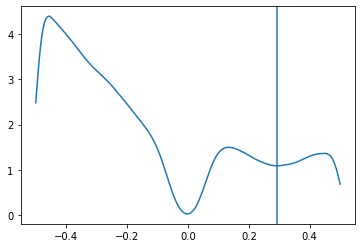

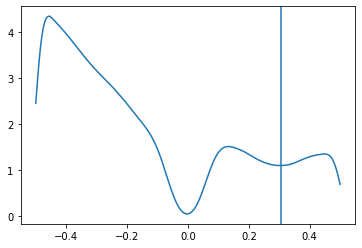

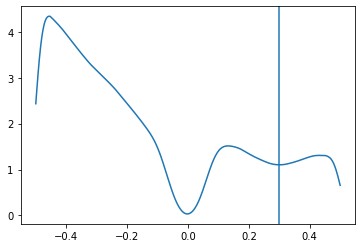

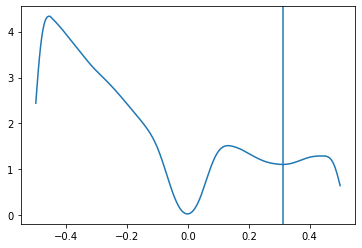

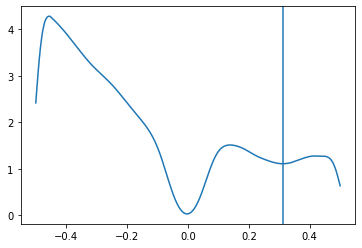

In [777]:
N_RANGE = (385, 446)
files = file_list(N_RANGE)
e = []
# for i, f in enumerate(files):
#     df = file2df(f)
#     if i < 8:
#         e.append(fit_dirac(df, crop=(-0.1, 0.08), fit_window=(-0.15, 0.15), right=True, fname=f))
#     elif i < 10:
#         e.append(fit_dirac(df, crop=(-0, 0), fit_window=(-0.15, 0.15), right=True, fname=f))
#     elif i < 17:
#         e.append(fit_dirac(df, crop=(-0.085, 0.09), fit_window=(-0.11, 0.1), fname=f))
#     else:
#         e.append(fit_dirac(df, crop=(-0.09, 0.11), fit_window=(-0.12, 0.12), fname=f))
for i, f in enumerate(files):
    df = file2df(f)
    if i < 7:
        e.append(find_min(df, guess=-0.2, sig=10))
    elif i < 11:
        e.append(fit_dirac(df, crop=(-0.02, 0.02), fit_window=(-0.15, 0.15), right=True, fname=f))
    else:
        e.append(find_min(df, guess=0.2, sig=10))

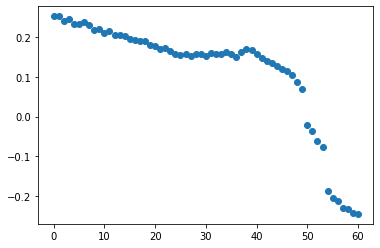

In [778]:
plt.plot(np.array(e[::-1]), 'o')

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


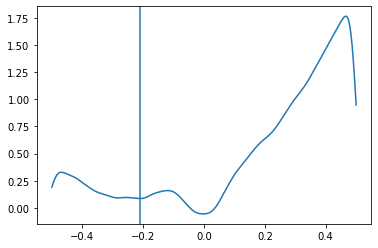

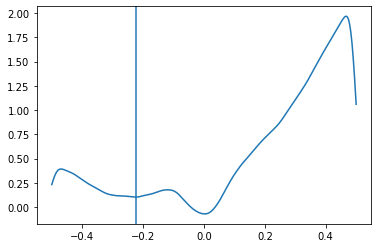

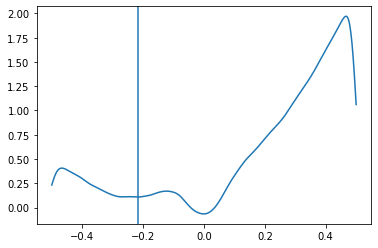

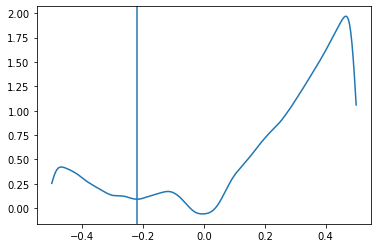

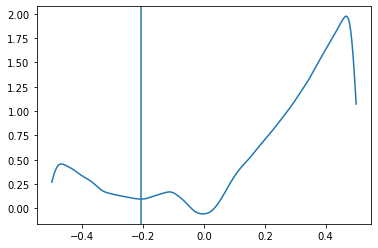

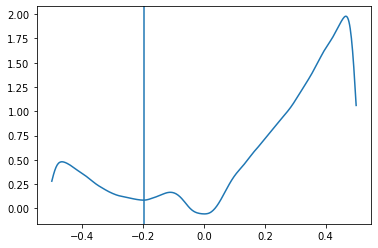

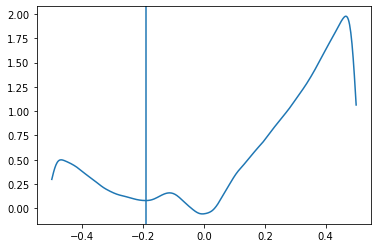

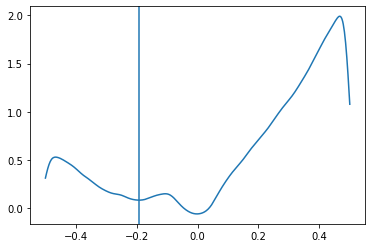

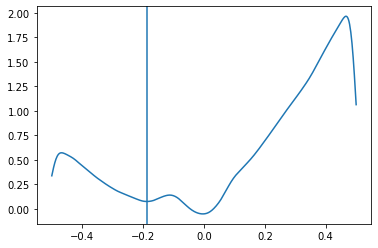

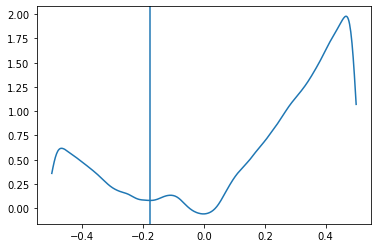

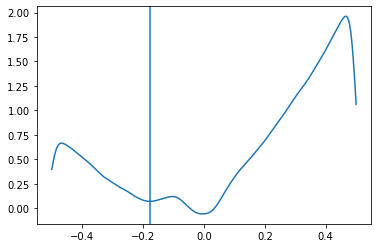

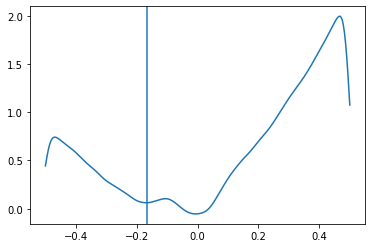

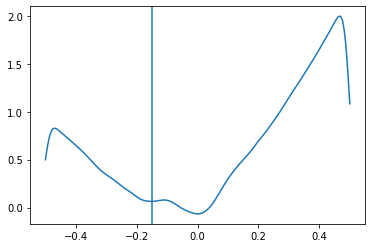

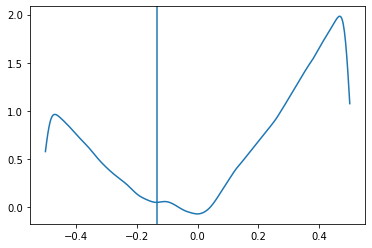

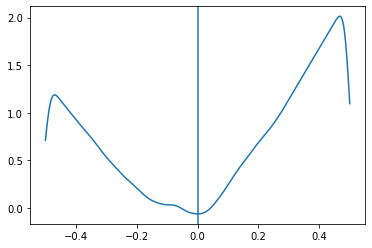

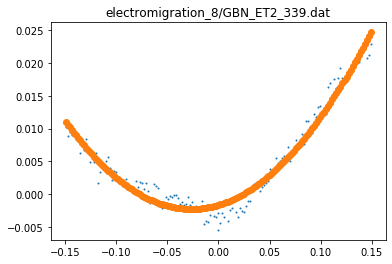

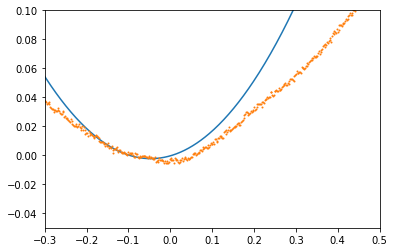

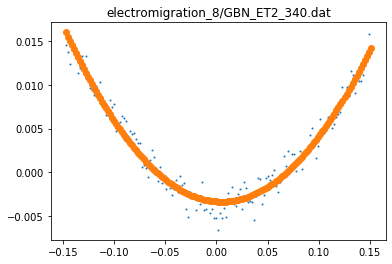

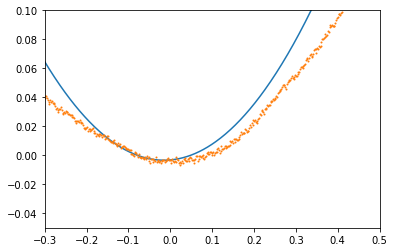

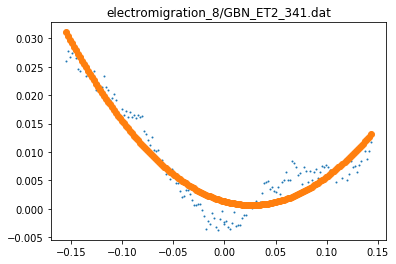

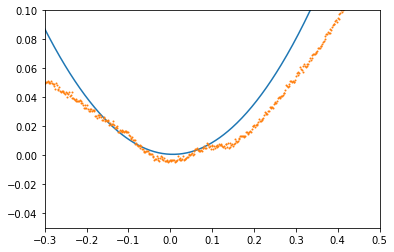

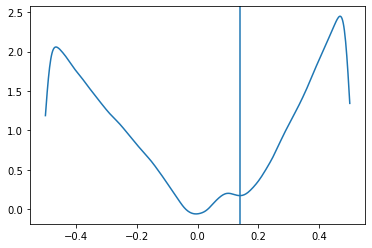

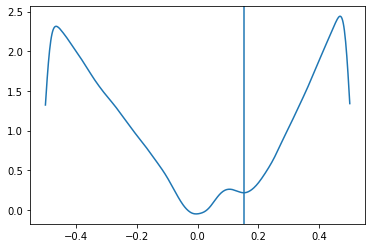

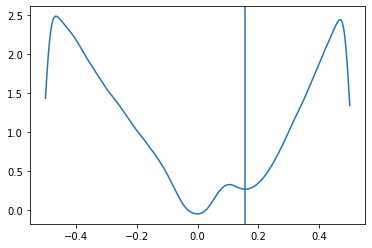

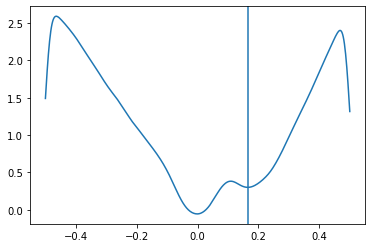

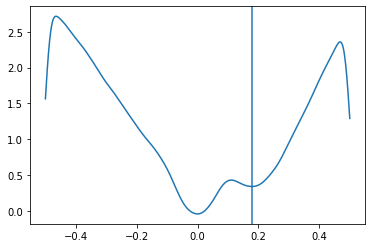

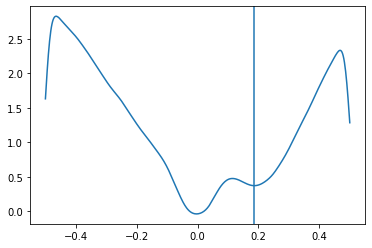

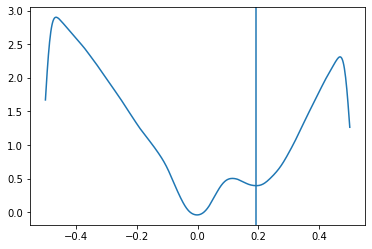

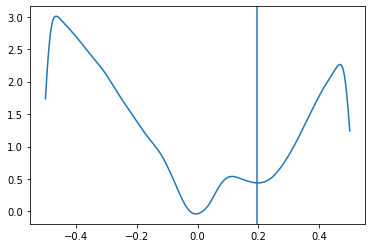

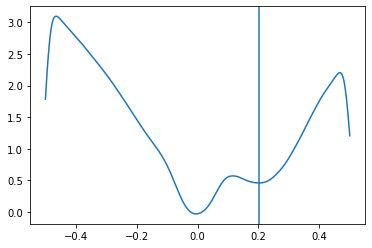

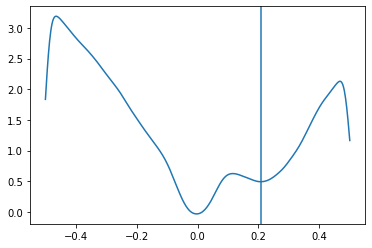

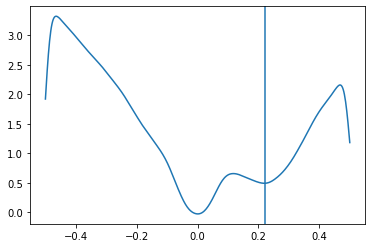

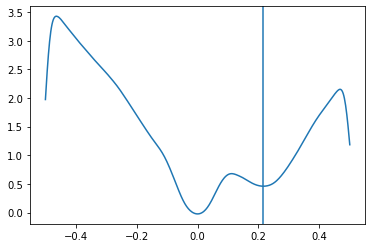

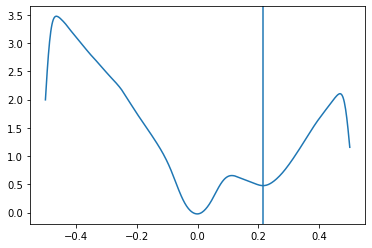

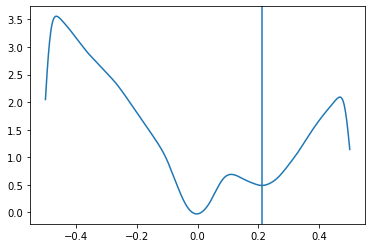

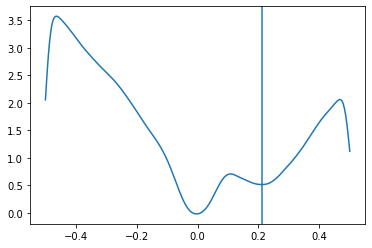

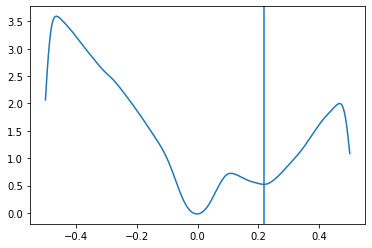

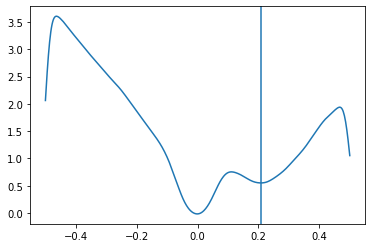

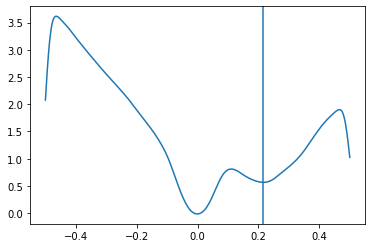

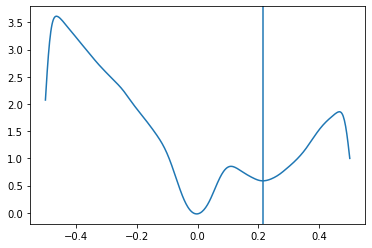

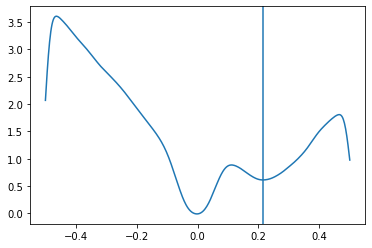

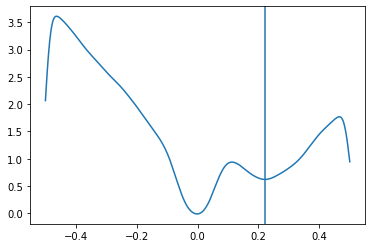

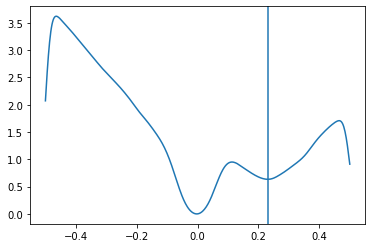

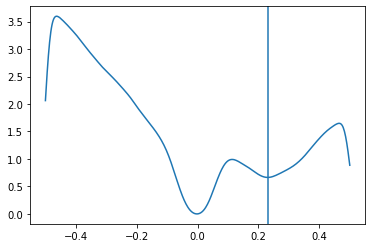

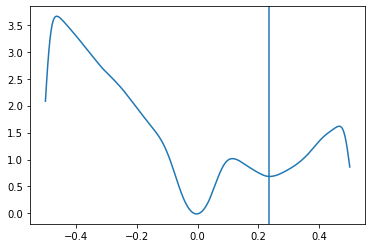

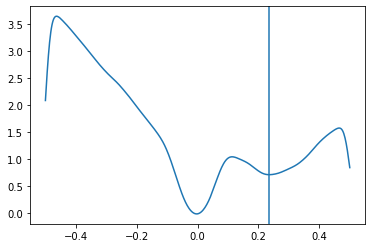

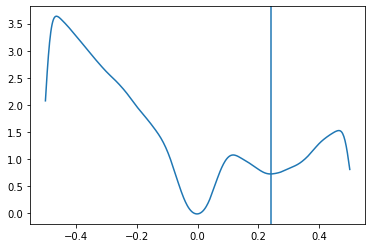

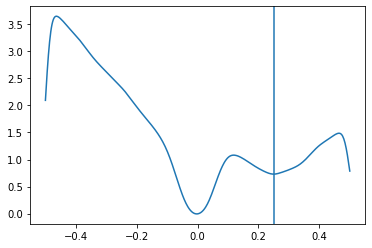

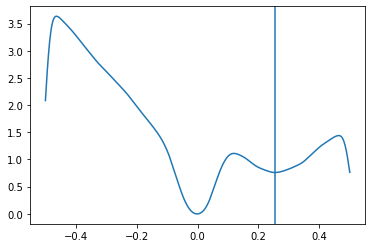

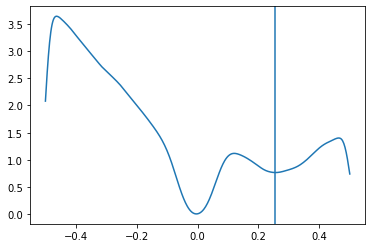

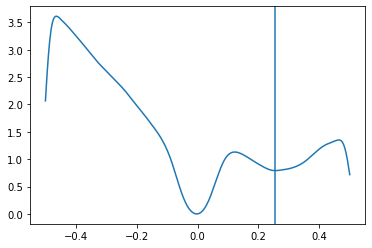

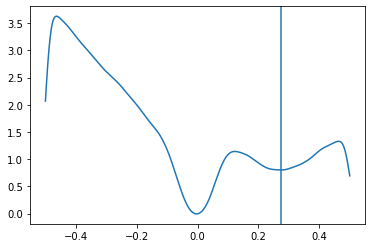

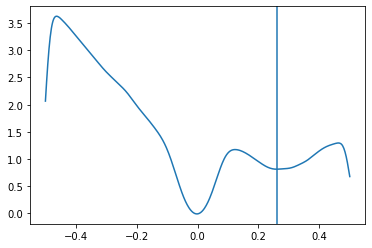

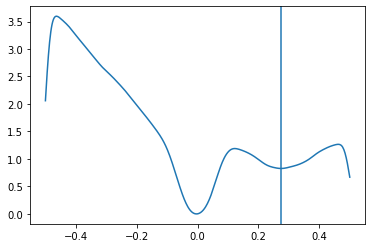

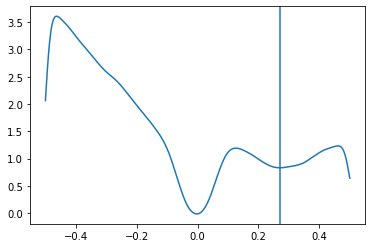

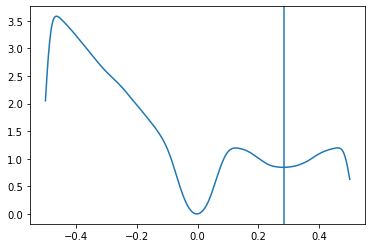

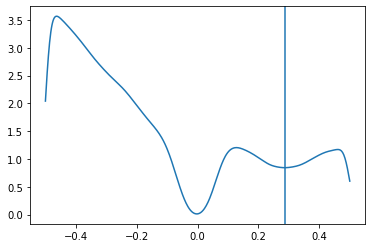

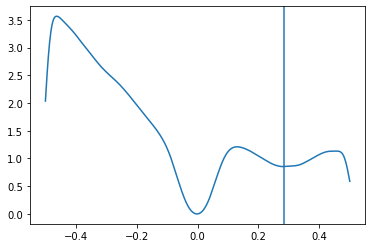

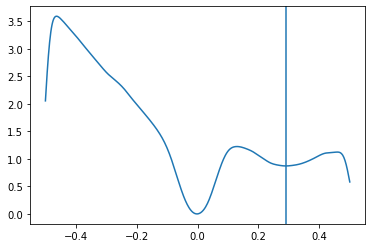

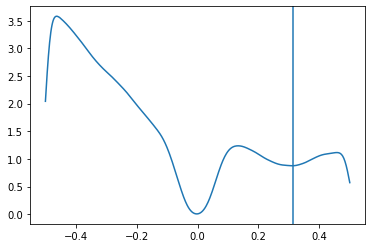

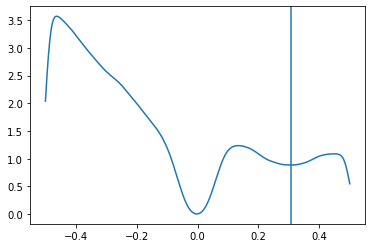

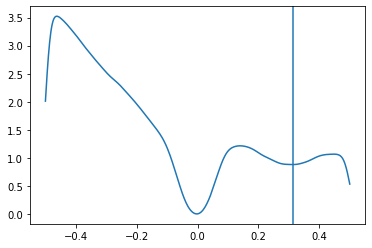

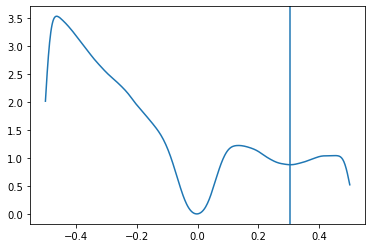

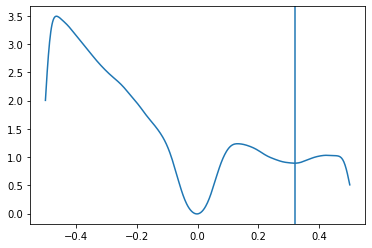

In [779]:
N_RANGE = (324, 385)
files = file_list(N_RANGE)
g = []
for i, f in enumerate(files):
    df = file2df(f)
#     if i < 20:
#         g.append(fit_dirac(df, crop=(-0.09, 0.09), fit_window=(-0.15, 0.15), fname=f))
#     else:
#         g.append(fit_dirac(df, crop=(-0.1, 0.1), fit_window=(-0.15, 0.15), fname=f))
    if i < 15:
        g.append(find_min(df, guess=-0.2, sig=8))
    elif i < 18:
        g.append(fit_dirac(df, crop=(-0.02, 0.02), fit_window=(-0.15, 0.15), right=False, fname=f))
    else:
        g.append(find_min(df, guess=0.2, sig=8))

(-0.3, 0.3)

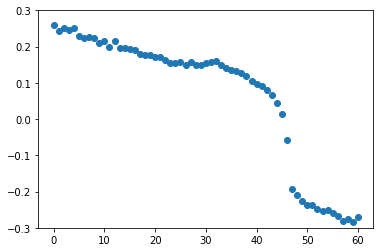

In [780]:
plt.plot(np.array(g[::-1]), 'o')
plt.ylim(-0.3, 0.3)

In [849]:
np.linspace(-60,0,7)

array([-60., -50., -40., -30., -20., -10.,   0.])

(-0.35, 0.3)

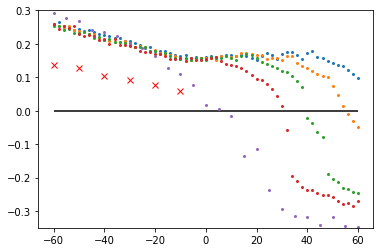

In [856]:
voltages = np.linspace(-60,60,61)
plt.plot(voltages,c[::-1], 'o', markersize=2)
plt.plot(voltages,d[::-1], 'o', markersize=2)
plt.plot(voltages,e[::-1], 'o', markersize=2)
plt.plot(voltages,g[::-1], 'o', markersize=2)
plt.plot(v,h_avg, 'o', markersize=2)
#plt.plot(h, 'o', markersize=1)
#plt.plot([-60,-40,-20,0,10],[0.25,0.196,0.176,0.15,0.114]-np.ones(5)*0.1,'rx')
#plt.plot(np.linspace(-60,0,7),[0.164,0.150,0.135,0.117,0.100,0.082,0.055],'rx')
plt.plot(np.linspace(-60,-10,6),[0.2361,0.2284,0.2047,0.1906,0.1781,0.160]-np.ones(6)*0.1,'rx')
plt.hlines(0,-60,60)
plt.ylim(-0.35,0.3)

In [781]:
PATH = "electromigration_7/GBN_ET2_"
N_RANGE = (8, 83)
file_list = lambda nrange : [PATH + '{0:03}.dat'.format(i) for i in range(*nrange)]

In [782]:
len(files)

61

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this w

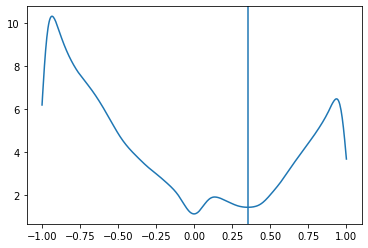

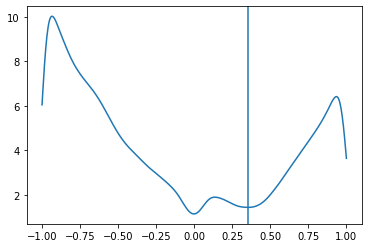

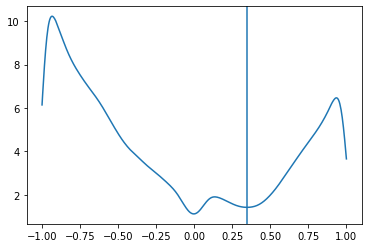

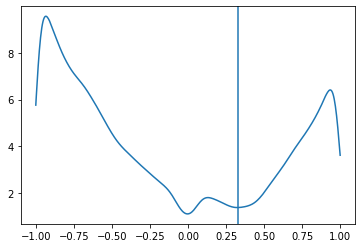

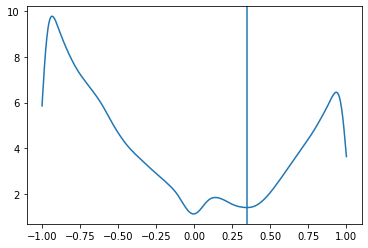

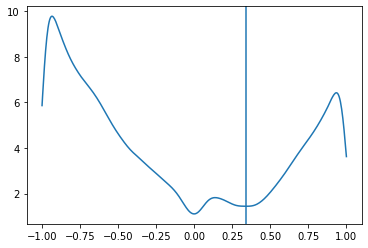

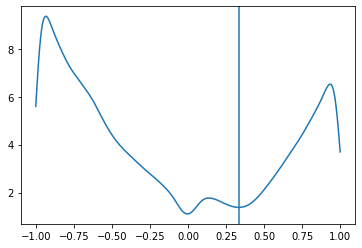

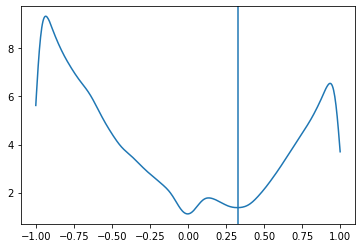

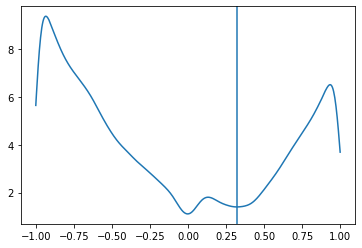

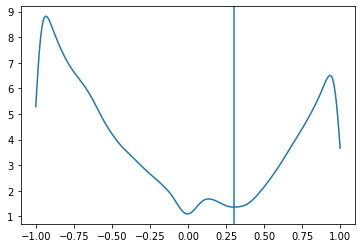

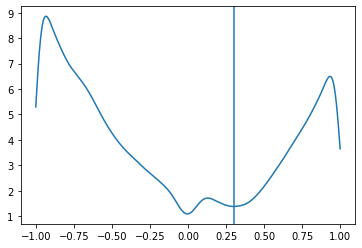

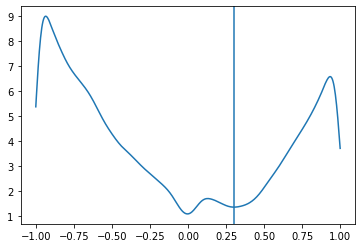

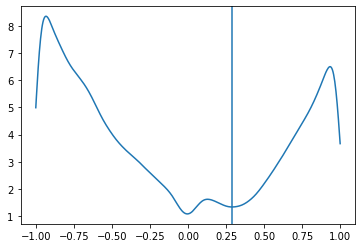

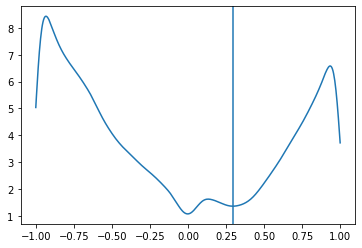

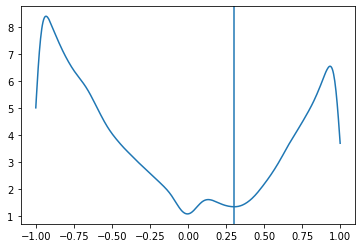

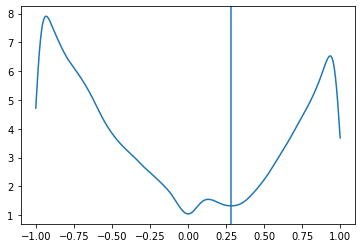

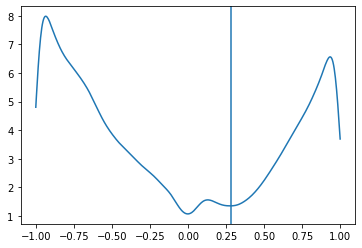

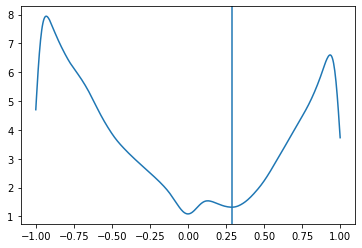

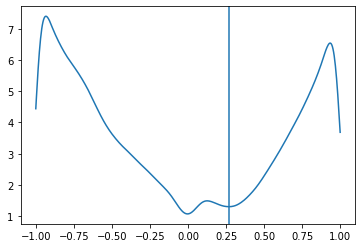

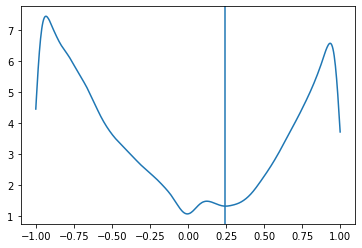

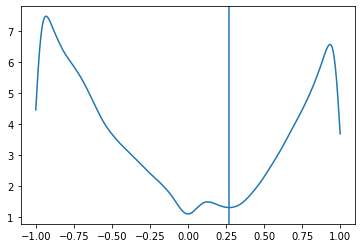

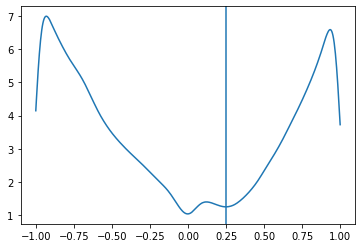

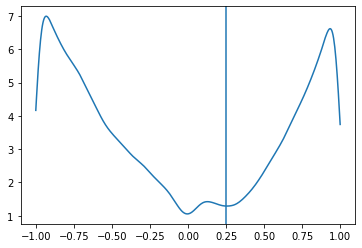

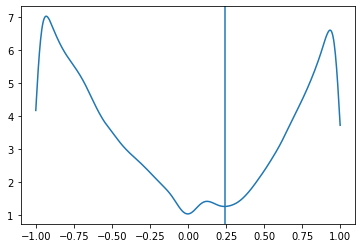

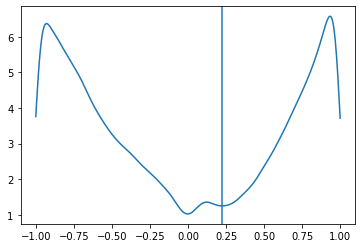

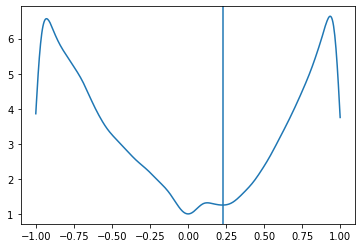

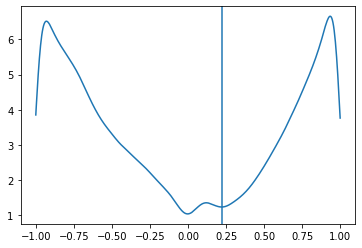

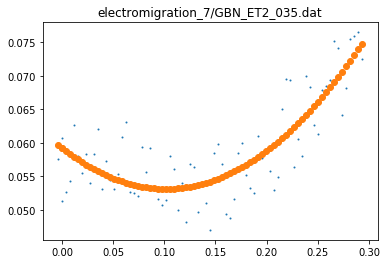

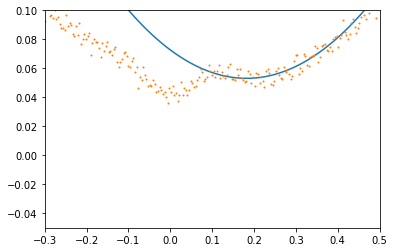

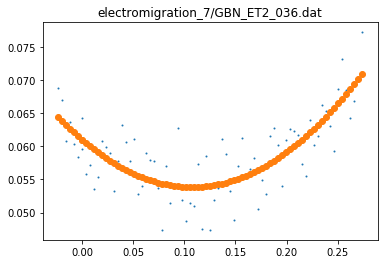

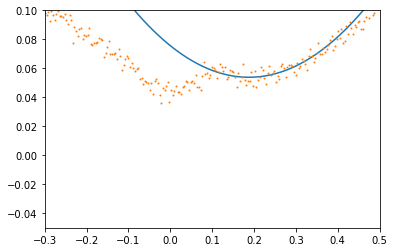

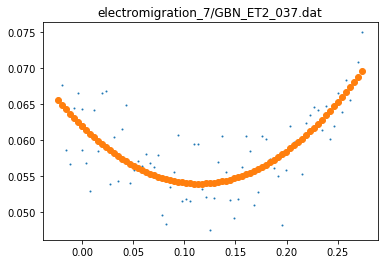

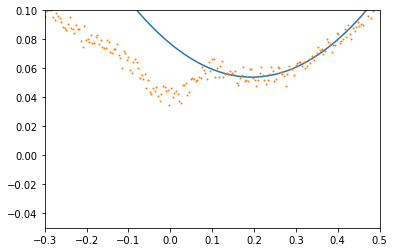

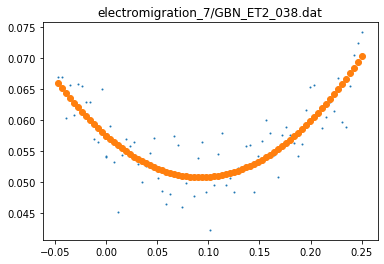

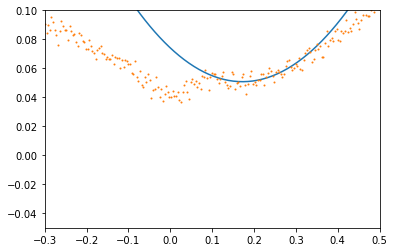

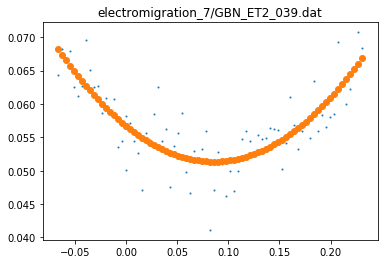

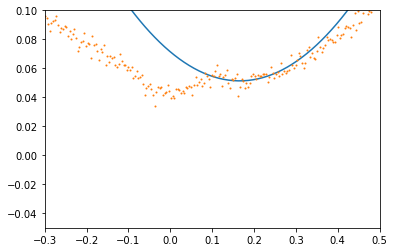

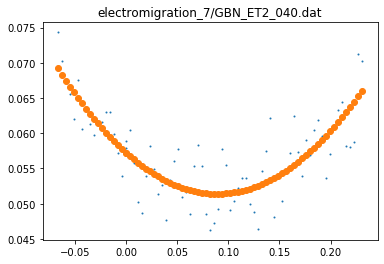

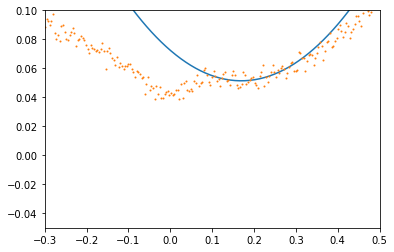

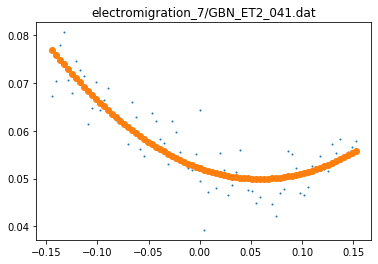

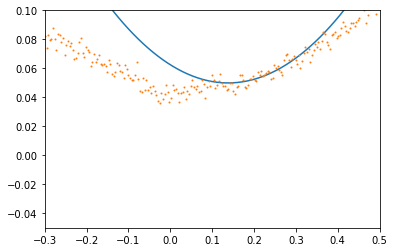

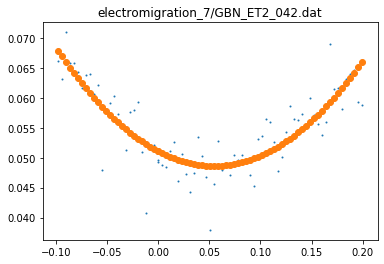

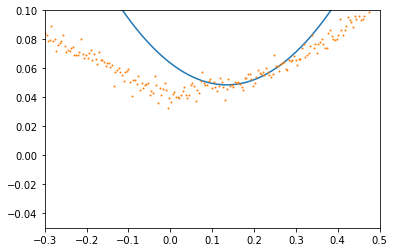

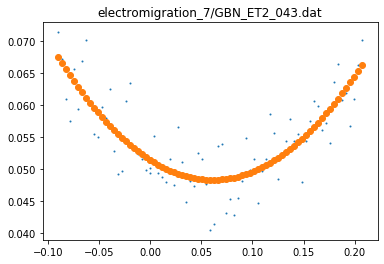

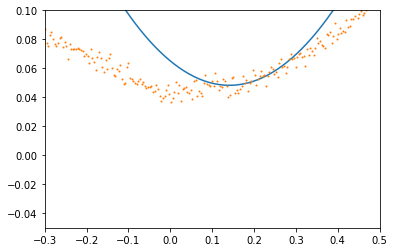

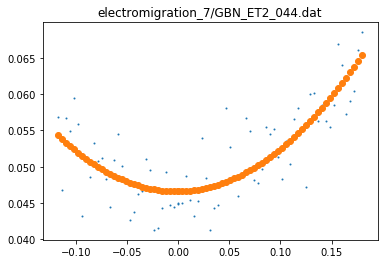

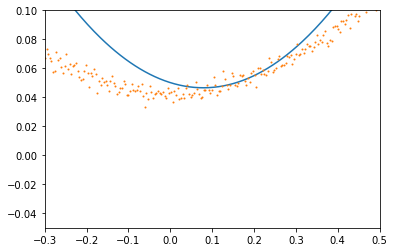

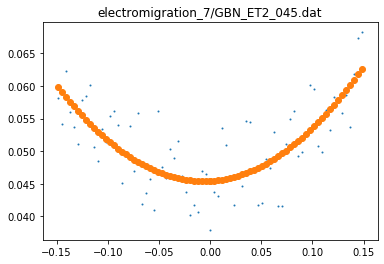

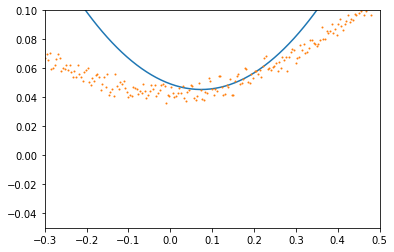

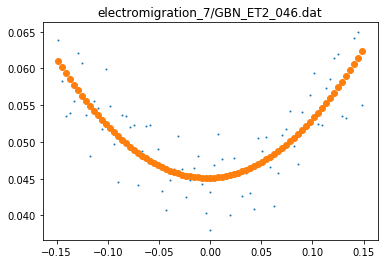

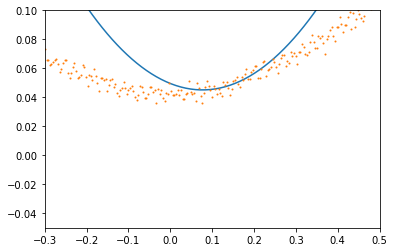

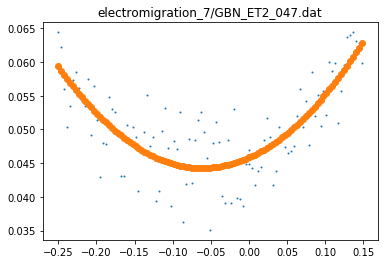

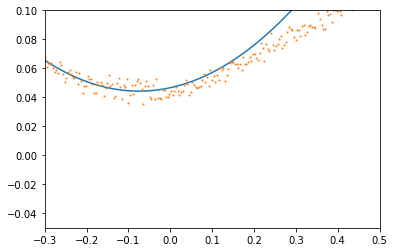

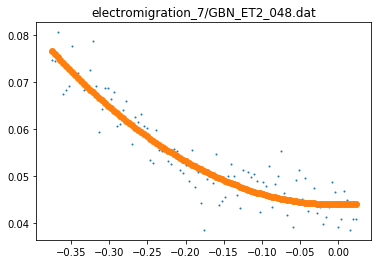

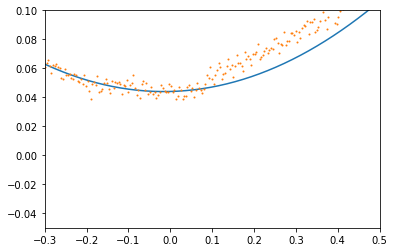

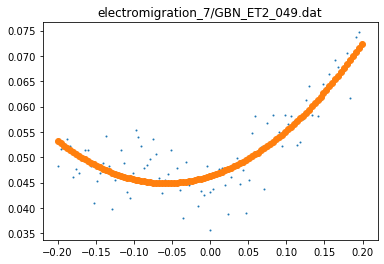

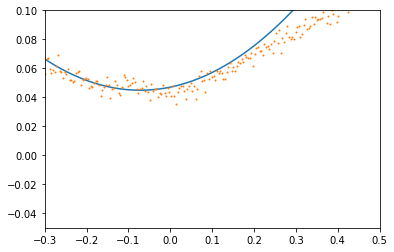

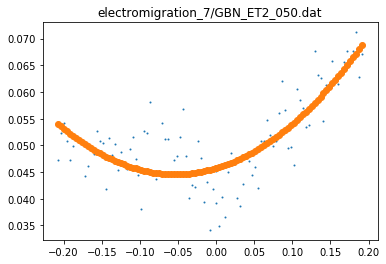

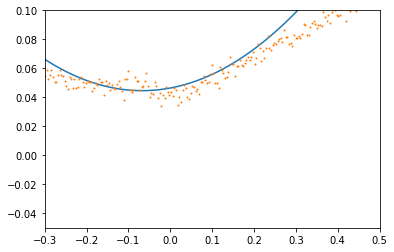

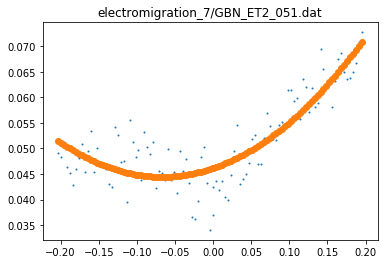

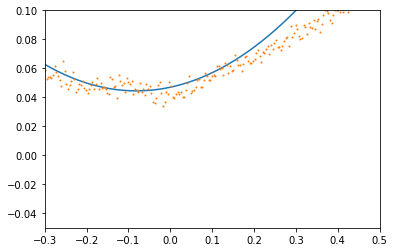

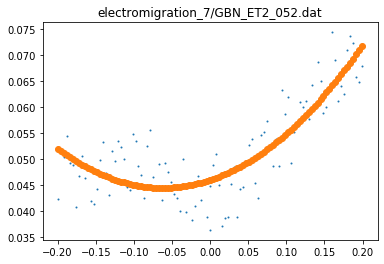

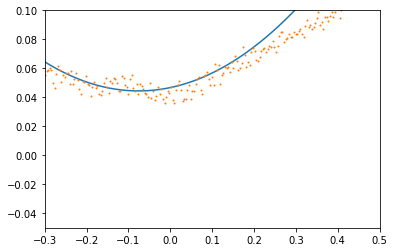

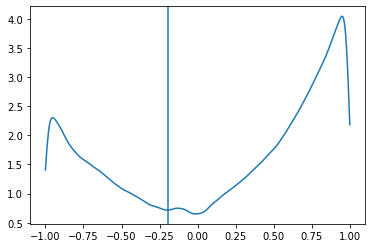

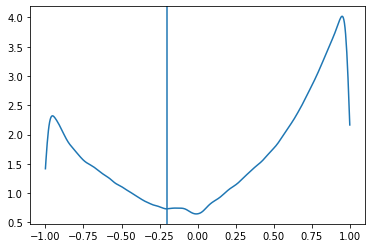

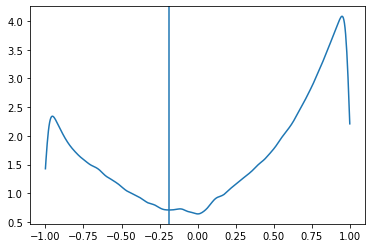

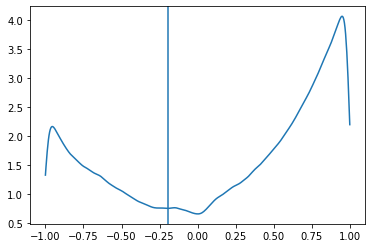

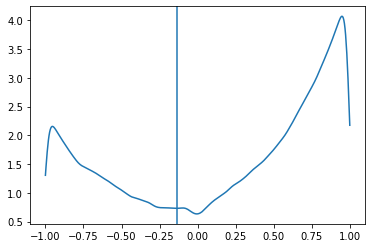

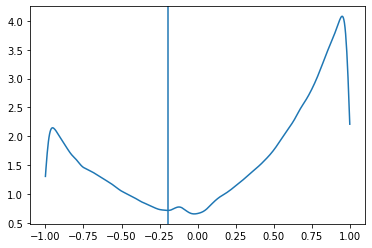

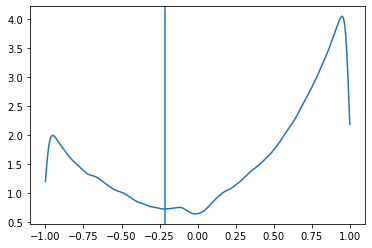

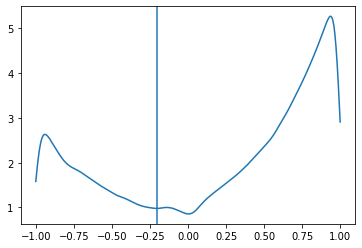

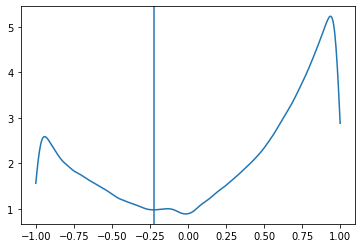

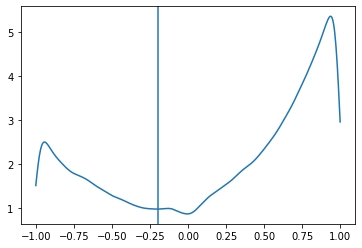

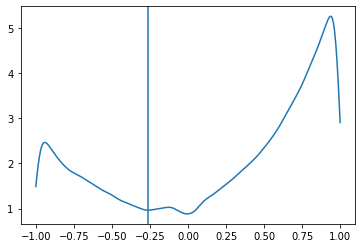

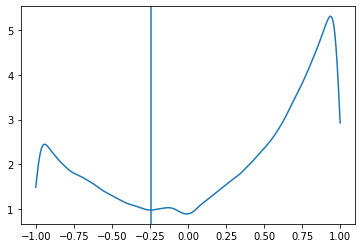

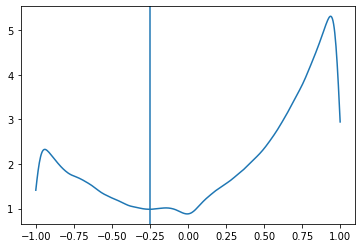

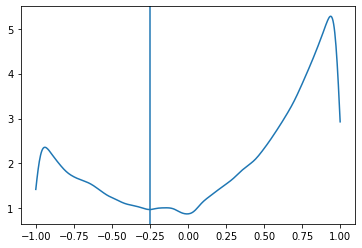

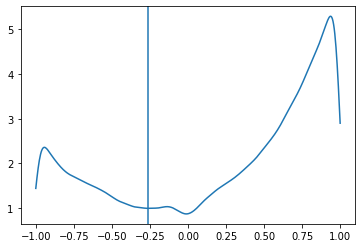

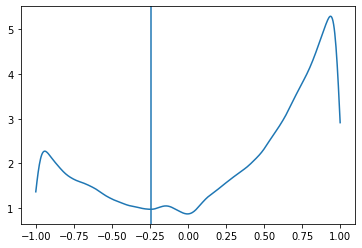

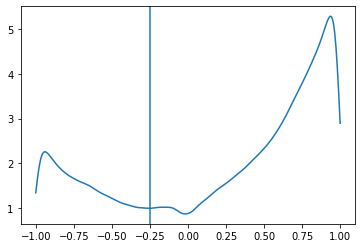

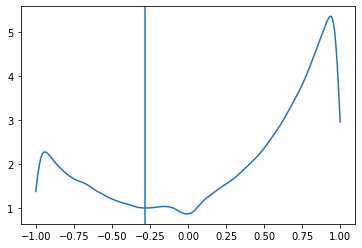

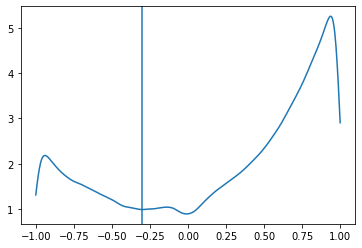

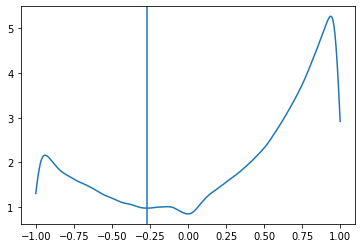

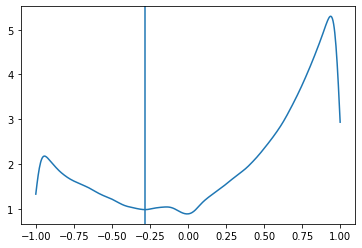

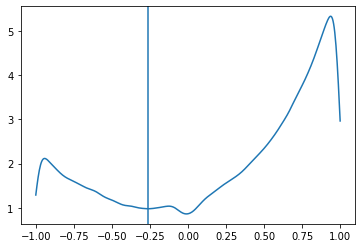

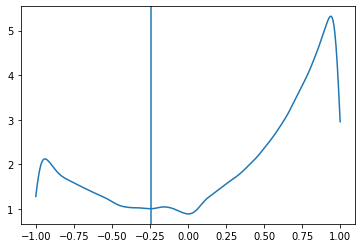

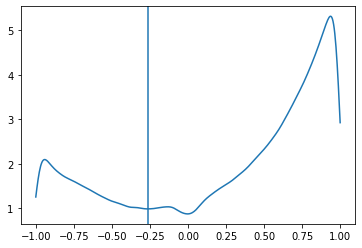

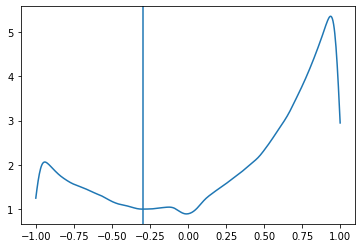

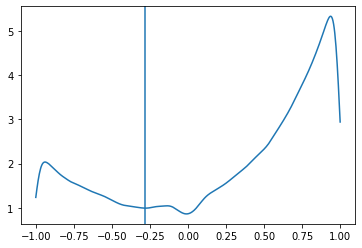

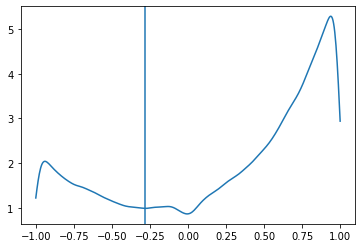

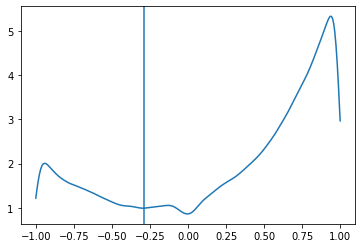

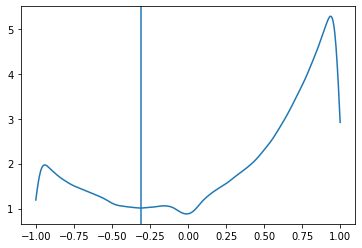

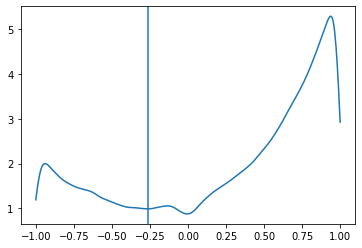

In [783]:
files = file_list(N_RANGE)
h = []
# for f in files:
#     df = file2df(f)
#     h.append(fit_dirac(df, crop=(-0.12, 0.12), fit_window=0.3))
for i, f in enumerate(files):
    df = file2df(f)
    if i < 27:
        h.append(find_min(df, guess=0.2, sig=9, phon_correct=True))
    elif i < 39:
        h.append(fit_dirac(df, crop=(-0.08, 0.08), fit_window=(-0.15, 0.15), right=True, fname=f))
    elif i < 45:
        h.append(fit_dirac(df, crop=(-0.01, 0.01), fit_window=(-0.20, 0.20), right=False, fname=f))
    elif i < 52:
        h.append(find_min(df, guess=-0.15, sig=6, phon_correct=True))
#     else:
#         g.append(fit_dirac(df, crop=(-0.1, 0.1), fit_window=(-0.15, 0.15), fname=f))
#     if i > 40:
#         h.append(find_min(df, guess=-0.2, sig=6, phon_correct=True))
#     elif i > 30:
#         h.append(fit_dirac(df, crop=(-0.01, 0.01), fit_window=(-0.2, 0.2), right=True, fname=f))
#     elif i > 26:
#         h.append(fit_dirac(df, crop=(-0.01, 0.01), fit_window=(-0.2, 0.2), right=False, fname=f))
    else:
        h.append(find_min(df, guess=-0.2, sig=8, phon_correct=False))

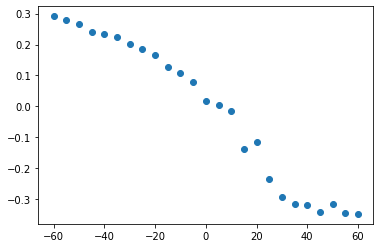

In [784]:
from scipy.ndimage import convolve1d
h_avg = convolve1d(h, weights=[1/3, 1/3, 1/3])[1::3]
v = np.linspace(-60, 60, 25)
plt.plot(v, h_avg, "o")